In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
grayImage = r'albert-einstein_gray.jpg'
I_gray = cv2.imread(grayImage,cv2.IMREAD_GRAYSCALE)

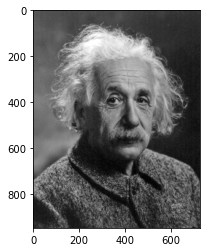

In [3]:
plt.imshow(I_gray,cmap='gray')
plt.show()

In [4]:
numRows = I_gray.shape[0]
numCols = I_gray.shape[1]
print(numRows, numCols)

949 728


In [5]:
import matplotlib as mpl
def displayImageInActualSize(I):
    dpi = mpl.rcParams['figure.dpi']
    H,W = I.shape
    figSize = W/float(dpi) , H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(I,cmap='gray')
    plt.show

## Bilinear Interpolate Function

In [6]:
def BilinearInterpolate(r,c,I):
    lc = int(c)
    rc = lc+1
    wr = c - lc
    wl = rc - c
    tr = int(r)
    br = tr+1
    wt = br-r
    wb = r-tr
    if tr >= 0 and br < I.shape[0] and lc >=0 and rc < I.shape[1]:
        a = wl*I[tr,lc] + wr*I[tr,rc]
        b = wl*I[br,lc] + wr*I[br,rc]
        g = wt*a + wb*b
        return np.uint8(g)
    else:
        return 0

## Rotation Code

In [7]:
a = 45
cosa = np.cos(np.deg2rad(a))
sina = np.sin(np.deg2rad(a))
R = np.array([[cosa,-sina],[sina,cosa]])
rMax,cMax = I_gray.shape[0],I_gray.shape[1]
Cords = np.array([[0,0],[0,cMax - 1],[rMax - 1,0],[rMax - 1,cMax - 1]])
A_dash = R.dot(Cords.T)
mins = A_dash.min(axis=1)
maxs = A_dash.max(axis=1)
minRow = np.int64(np.floor(mins[0]))
minCol = np.int64(np.floor(mins[1]))
maxRow = np.int64(np.ceil(maxs[0]))
maxCol = np.int64(np.ceil(maxs[1]))
H,W = maxRow - minRow + 1, maxCol - minCol + 1
I2 = np.zeros((H,W),dtype='uint8')

In [8]:
Tinv = np.linalg.inv(R)
for new_i in range(minRow, maxRow):
    for new_j in range(minCol, maxCol):
        P_dash = np.array([new_i,new_j])
        P = Tinv.dot(P_dash)
        i , j = P[0] , P[1]
        if i < 0 or i >= numRows or j < 0 or j >= numCols:
            pass
        else:
            g = BilinearInterpolate(i,j,I_gray)
            I2[new_i - minRow, new_j - minCol] = g

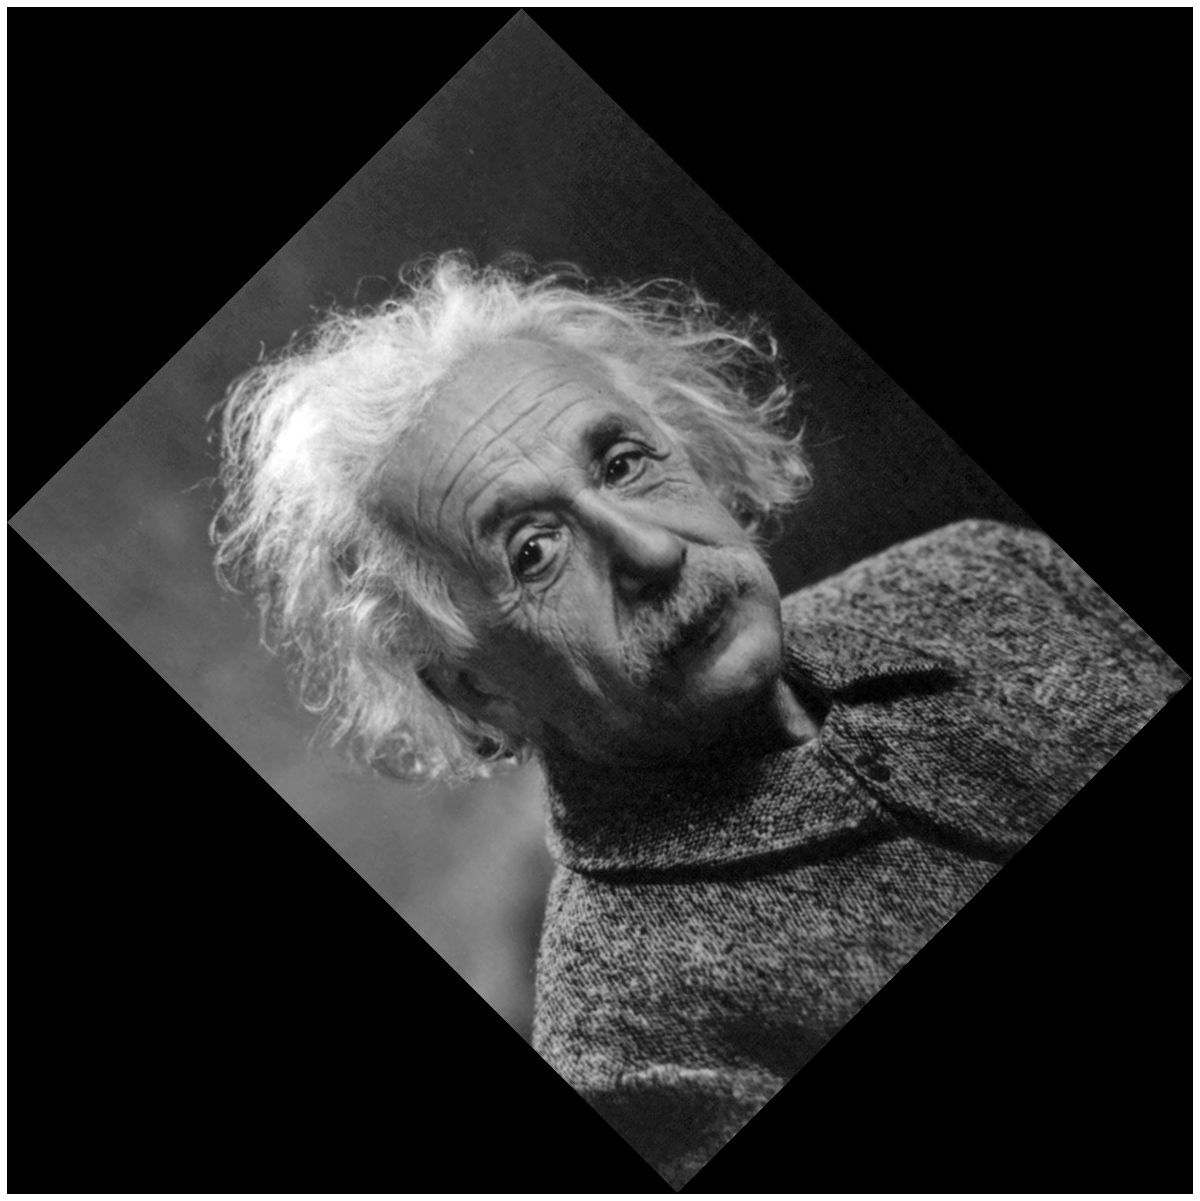

In [9]:
displayImageInActualSize(I2)

## Rotation built-in fuction in OpenCV

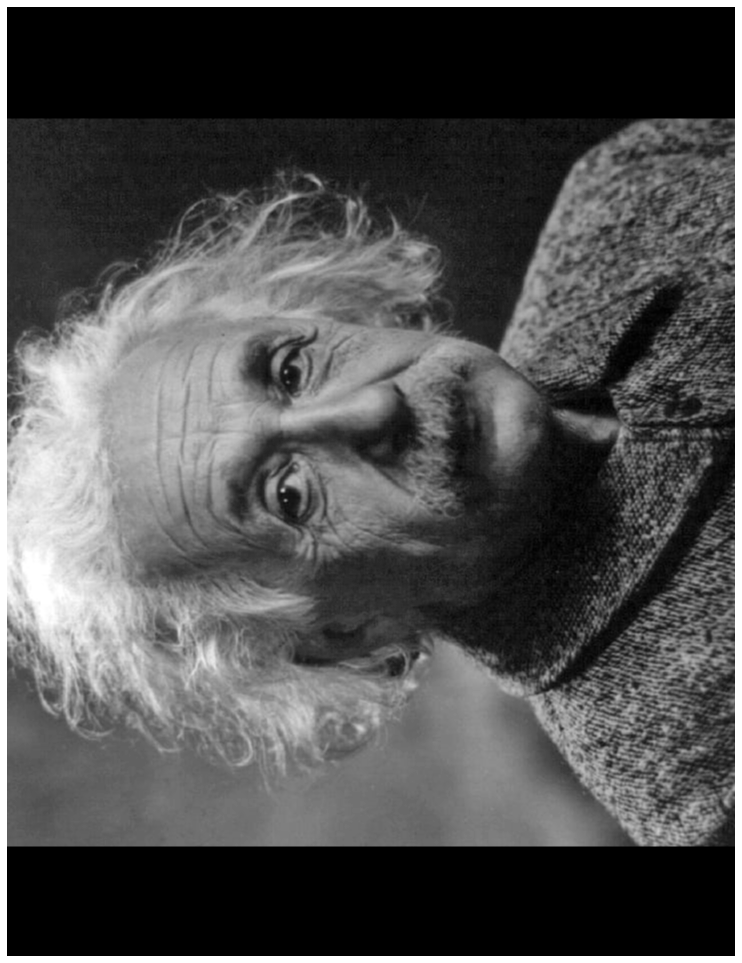

In [10]:
image = I_gray
center = tuple(np.array(image.shape[1::-1])/2) # reverse rows and cols
angle = 90 # angle > 0 => anti clockwise, angle < 0 => clockwise

matrix = cv2.getRotationMatrix2D(center, angle, 1)
result =  cv2.warpAffine(image, matrix, image.shape[1::-1])

displayImageInActualSize(result)

<strong>NOTE</strong>: Ở máy tính, tọa độ của ảnh đc trưng bày theo dạng gốc tọa độ ở góc trên trái cùng của ảnh</br>
<t>trục Ox của hệ tọa độ máy là Oy trong toán học thực tế</t></br>
<t> trục Oy của hệ tọa độ máy là Ox trong toán học thực tế</t></br>
<t> Vì thế phải đảo ngược lại để về dạng chuẩn.

In [11]:
image.shape[1::-1]

(728, 949)

## Transform Function

In [12]:
def getExtents(T,rMax,cMax):
    Cords = np.array([[0,0],[0,cMax-1],[rMax-1,0],[rMax-1,cMax-1]])
    A_dash = T.dot(Cords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR-minR+1, maxC-minC+1
    return minR,minC,maxR,maxC,H,W

In [13]:
def Transform(T,I_gray): # T là ma trận hệ số
    rMax,cMax = I_gray.shape[0],I_gray.shape[1]
    minR,minC,maxR,maxC,H,W = getExtents(T,rMax,cMax)
    I2 = np.zeros((H,W),dtype='uint8')
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            P_dash = np.array([new_i,new_j])
            P = Tinv.dot(P_dash)
            i , j = P[0] , P[1]
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = BilinearInterpolate(i,j,I_gray)
                I2[new_i-minR,new_j-minC] = g
    return I2

## Reflection

In [14]:
T = np.array([[-1,0],[0,1]]) # đối xứng qua trục x

In [15]:
I2 = Transform(T,I_gray)

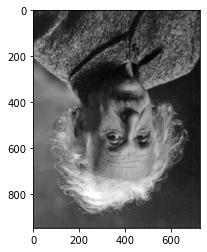

In [16]:
plt.imshow(I2,cmap='gray')

In [17]:
T = np.array([[1,0],[0,-1]]) # đối xứng qua trục y

In [18]:
image = Transform(T,I_gray)

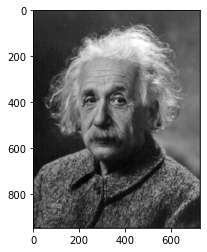

In [19]:
plt.imshow(image,cmap='gray')

# Built - in function for reflection

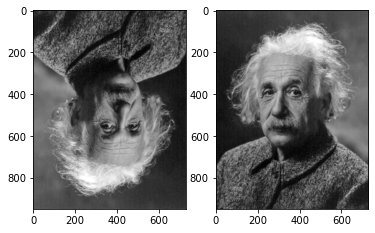

In [20]:
img_result1 = cv2.flip(I_gray, 0) # đối xứng qua trục Ox
img_result2 = cv2.flip(I_gray, 1) # đối xứng qua trục Oy

plt.subplot(121)
plt.imshow(img_result1, cmap = 'gray')
plt.subplot(122)
plt.imshow(img_result2, cmap = 'gray')

## Sheer

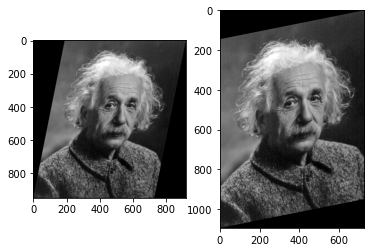

In [23]:
k = -0.2
alpha = np.array([[1,0],[k,1]])
beta = np.array([[1,k],[0,1]])
ost = Transform(alpha,I_gray)
otp = Transform(beta,I_gray)

plt.subplot(121)
plt.imshow(ost, cmap = 'gray')
plt.subplot(122)
plt.imshow(otp, cmap = 'gray')